In [1]:
from quests_data import *
from ase.io import read
from quests.tools.plotting import savefig, COLORS

## Defining a few useful functions to process the data

In [2]:
def clean_filename(name):
    return name.split("/")[-1].strip(".xyz")

def get_int(name):
    match = re.findall("[0-9]+", name)[0]
    return int(match)
    
def get_forces_rmse(dset):
    true, pred = [], []
    for at in dset:
        true.append(at.get_forces())
        pred.append(at.arrays["MACE_forces"])
    
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    
    error = (true - pred) ** 2
    return np.sqrt(error.mean())

def get_num_envs(dset):
    return sum([
        len(at) for at in dset
    ])

def get_df(dset_name, root_dir="../data/02-GAP20/compress"):
    df = []
    for i in range(2, 11):
        name = f"{dset_name}-{i:02d}"
        path = f"{root_dir}/{dset_name}/{name}"
        results_file = f"{path}/{dset_name}-test.xyz"

        if not os.path.exists(results_file):
            continue

        res = read(results_file, index=":")
        with open(f"{path}/entropy.json", "r") as f:
            data = json.load(f)

        df.append({
            "i": i,
            "n": data["n_envs"],
            "pct": i * 10,
            "rmse": get_forces_rmse(res) * 1000,
            "entropy": data["entropy"],
        })

    df = pd.DataFrame(df)
    return df

## Loading and analyzing the data

In [3]:
gr = get_df("graphene")
fu = get_df("fullerenes")

In [4]:
gr["drmse"] = gr["rmse"] - gr.iloc[-1]["rmse"]
fu["drmse"] = fu["rmse"] - fu.iloc[-1]["rmse"]

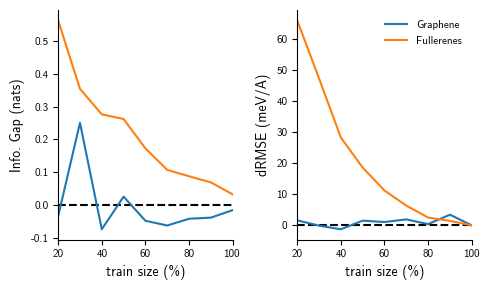

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(5, 3), sharex=True)

xticks = np.array([20, 40, 60, 80, 100])


ax = axs[0]
ax.plot([20, 100], [0, 0], "k--")
ax.plot(gr["pct"], 4.245 - gr["entropy"])
ax.plot(fu["pct"], 8.679 - fu["entropy"])
ax.set_ylabel("Info. Gap (nats)")
ax.set_xlabel("train size (%)")

ax = axs[1]
ax.plot([20, 100], [0, 0], "k--")
ax.plot(gr["pct"], gr["drmse"], label="Graphene")
ax.plot(fu["pct"], fu["drmse"], label="Fullerenes")
ax.set_ylabel("dRMSE (meV/A)")
ax.set_xlabel("train size (%)")

ax.legend(frameon=False, fontsize=8)

ax.set_xticks(xticks)
ax.set_xlim(xticks[0], xticks[-1])

fig.tight_layout()

# savefig(fig, "04-dset-curves.pdf")
plt.show()